In [11]:
import json
import pandas as pd
import gzip

def parse(path):
  g = gzip.open(path, 'rb')
  for l in g:
    yield json.loads(l)

def getDF(path):
  i = 0
  df = {}
  for d in parse(path):
    df[i] = d
    i += 1
  return pd.DataFrame.from_dict(df, orient='index')


meta_df = getDF('/ssd1/holdenhu/Amazon_dataset/Amazon_Fashion/raw/meta_AMAZON_FASHION.json.gz')
# review_df = getDF('/ssd1/holdenhu/feature_dataset/Amazon_Fashion/raw/review_AMAZON_FASHION_5.json.gz')

In [12]:
meta_df.head()

,title,brand,feature,rank,date,asin,imageURL,imageURLHighRes,description,price,also_view,also_buy,fit,details,similar_item,tech1
0,Slime Time Fall Fest [With CDROM and Collector...,Group Publishing (CO),[Product Dimensions:\n \n8....,"13,052,976inClothing,Shoesamp;Jewelry(",8.70 inches,0764443682,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,XCC Qi promise new spider snake preparing men'...,NaN,NaN,"11,654,581inClothing,Shoesamp;Jewelry(",5 star,1291691480,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Magical Things I Really Do Do Too!,Christopher Manos,[Package Dimensions:\n \n8....,"19,308,073inClothing,ShoesJewelry(",5 star,1940280001,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...,[For the professional or amateur magician. Ro...,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,"Ashes to Ashes, Oranges to Oranges",Flickerlamp Publishing,[Package Dimensions:\n \n8....,"19,734,184inClothing,ShoesJewelry(",5 star,1940735033,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Aether & Empire #1 - 2016 First Printing Comic...,NaN,[Package Dimensions:\n \n10...,"10,558,646inClothing,Shoesamp;Jewelry(",5 star,1940967805,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...,NaN,$4.50,NaN,NaN,NaN,NaN,NaN,NaN


In [17]:
meta_df.title[4]

'Aether & Empire #1 - 2016 First Printing Comic Book Special Edition - Rare! - Blue Juice Comics'

In [4]:
title_dict = {} # asin => title
drop_item_num = 0
for i in range(len(meta_df)):
    row = meta_df.iloc[i]
    title = row['title']
    if not pd.isna(title):
        if title[:39] == 'var aPageStart = (new Date()).getTime()':
            drop_item_num += 1
            continue
        title_dict[row['asin']]=row['title']
    else:
        drop_item_num += 1
print(drop_item_num,'item dropped')
title_corpus = [i[1].lower() for i in title_dict.items()]

435 item dropped


In [5]:
# https://www.kaggle.com/code/jbencina/clustering-documents-with-tfidf-and-kmeans

from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
stop = list(stopwords.words('english'))
stop.extend(['!','"','#','$','%','&','(',')','*','+',',','.','/',':',';','<','=','>','?','@','[','\\',']','^','_','`','{','|','}','~','\t','\n'])

corpus = title_corpus
# vectorizer = TfidfVectorizer(ngram_range=(1,2),stop_words=set(stop))
vectorizer = TfidfVectorizer(min_df = 5, max_df = 0.9, max_features = 8000, stop_words = 'english') # ignore terms that appear in less than 5 documents; ignore terms that appear in more than 90% of the documents
X = vectorizer.fit_transform(corpus)
words = vectorizer.get_feature_names_out()

Fit 2 clusters
Fit 4 clusters
Fit 6 clusters
Fit 8 clusters
Fit 10 clusters
Fit 12 clusters
Fit 14 clusters
Fit 16 clusters
Fit 18 clusters
Fit 20 clusters
Fit 22 clusters
Fit 24 clusters


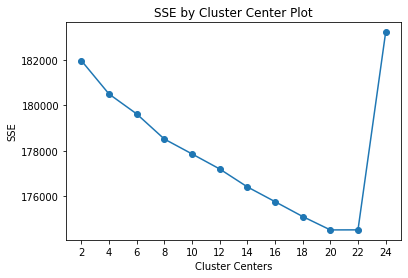

In [7]:
from sklearn.cluster import MiniBatchKMeans
import matplotlib.pyplot as plt

def find_optimal_clusters(data, max_k):
    iters = range(2, max_k+1, 2)
    
    sse = []
    for k in iters:
        sse.append(MiniBatchKMeans(n_clusters=k, init_size=1024, batch_size=2048, random_state=20).fit(data).inertia_)
        print('Fit {} clusters'.format(k))
        
    f, ax = plt.subplots(1, 1)
    ax.plot(iters, sse, marker='o')
    ax.set_xlabel('Cluster Centers')
    ax.set_xticks(iters)
    ax.set_xticklabels(iters)
    ax.set_ylabel('SSE')
    ax.set_title('SSE by Cluster Center Plot')
    
find_optimal_clusters(X, 25)

In [8]:
CLUSTER_NUM = 20
clusters = MiniBatchKMeans(n_clusters=CLUSTER_NUM, init_size=1024, batch_size=2048, random_state=20).fit_predict(X)

In [ ]:
import numpy as np

clusters_dict = {} # asin => cluster
asin_list = [i[0] for i in title_dict.items()]
for a,c in zip(asin_list, clusters):
    clusters_dict[a] = c

cluster_topic_dict = {} # cluster => topic_words
n_terms = 20
_df = pd.DataFrame(X.todense()).groupby(clusters).mean()    
for i,r in _df.iterrows(): # i cluster
    topic_words = [words[t] for t in np.argsort(r)[-n_terms:]]
    cluster_topic_dict[i] = topic_words

In [ ]:
### SAVE ###
import pickle
pickle.dump(title_dict, open('/ssd1/holdenhu/Amazon_dataset/Amazon_Fashion/processed/asin_title_dict.pickle', 'wb'))
pickle.dump(clusters_dict, open('/ssd1/holdenhu/Amazon_dataset/Amazon_Fashion/processed/asin_clusters{}_dict.pickle'.format(CLUSTER_NUM), 'wb'))
pickle.dump(cluster_topic_dict, open('/ssd1/holdenhu/Amazon_dataset/Amazon_Fashion/processed/cluster{}_topic_dict.pickle'.format(CLUSTER_NUM), 'wb'))

/home/holdenhu/miniconda3/envs/recbole/lib/python3.9/site-packages/sklearn/utils/validation.py:585: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
/home/holdenhu/miniconda3/envs/recbole/lib/python3.9/site-packages/sklearn/utils/validation.py:585: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
/home/holdenhu/miniconda3/envs/recbole/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/holdenhu/miniconda3/envs/recbole/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: 

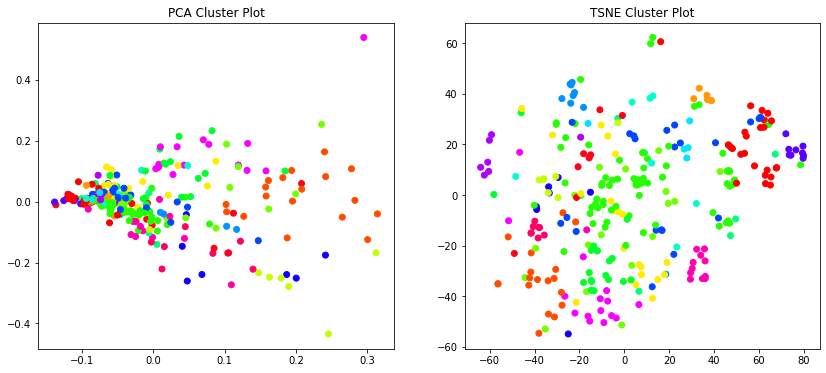

In [19]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.cm as cm


def plot_tsne_pca(data, labels):
    max_label = max(labels)
    max_items = np.random.choice(range(data.shape[0]), size=3000, replace=False)
    
    pca = PCA(n_components=2).fit_transform(data[max_items,:].todense())
    tsne = TSNE().fit_transform(PCA(n_components=50).fit_transform(data[max_items,:].todense()))
    
    idx = np.random.choice(range(pca.shape[0]), size=300, replace=False)
    label_subset = labels[max_items]
    label_subset = [cm.hsv(i/max_label) for i in label_subset[idx]]
    
    f, ax = plt.subplots(1, 2, figsize=(14, 6))
    
    ax[0].scatter(pca[idx, 0], pca[idx, 1], c=label_subset)
    ax[0].set_title('PCA Cluster Plot')
    
    ax[1].scatter(tsne[idx, 0], tsne[idx, 1], c=label_subset)
    ax[1].set_title('TSNE Cluster Plot')
    
plot_tsne_pca(X, clusters)

In [15]:
for c,t in cluster_topic_dict.items():
    print('cluster {} has topic'.format(c),t[:10])

cluster 0 has topic ['heart', 'beads', 'watch', 'bangle', 'earrings', 'tone', 'ring', 'fashion', 'charm', 'plated']
cluster 1 has topic ['sexy', 'zanzea', 'dress', 'shoulder', 'xl', 'black', 'lace', 'shirts', 'womens', 'chiffon']
cluster 2 has topic ['hobo', 'backpack', 'black', 'pu', 'cross', 'satchel', 'handbags', 'clutch', 'travel', 'women']
cluster 3 has topic ['waist', 'medium', 'sport', 'tie', 'fit', 'cotton', 'big', 'tall', 'slim', 'black']
cluster 4 has topic ['bohemian', 'black', 'sleeve', 'evening', 'sexy', 'floral', 'print', 'womens', 'chiffon', 'boho']
cluster 5 has topic ['print', '14k', 'long', 'sleeve', 'womens', 'xl', 'small', 'neck', 'tank', 'medium']
cluster 6 has topic ['leather', 'set', 'fashion', 'shoes', 'tank', 'case', 'scarf', 'socks', 'watch', 'print']
cluster 7 has topic ['pink', 'long', 'tee', 'neck', 'grey', 'adult', 'navy', 'red', 'sleeve', 'hoodie']
cluster 8 has topic ['38', 'fashion', '36', '34', 'silver', 'elastic', 'faux', 'mens', 'wide', 'genuine']
cl

In [5]:
### Load
import pickle
asin_clusters20_dict = pickle.load(open('/ssd1/holdenhu/Amazon_dataset/Amazon_Fashion/processed/text/asin_clusters20_dict.pickle', 'rb'))
asin_title_dict = pickle.load(open('/ssd1/holdenhu/Amazon_dataset/Amazon_Fashion/processed/text/asin_title_dict.pickle', 'rb'))
cluster20_topic_dict = pickle.load(open('/ssd1/holdenhu/Amazon_dataset/Amazon_Fashion/processed/text/cluster20_topic_dict.pickle', 'rb'))

In [11]:
asin_title_dict['1291691480']

"XCC Qi promise new spider snake preparing men's accessories alloy fittings magnet buckle bracelet jewelry"

In [12]:
asin_clusters20_dict['1291691480']

0

In [ ]:
for k,v in cluster20_topic_dict.items():
    print('cluster-{}'.format(k),v[:10])